In [3]:
import re
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from pathlib import Path
import torch
from tqdm import tqdm
from skimage.io import imread
import torchvision
from torch.utils.data import Dataset
from snn_model.datasets import TripletPathDataset
from snn_model.model import EmbeddingNet, TripletNet
from snn_model.functions import accuracy
from snn_model.transformations import EmptyTransformation
import torch.nn as nn

In [13]:
root = Path('../../data/face_detection/processed/')

In [14]:
def walkdir(folder):
    """Walk through every files in a directory"""
    for dirpath, dirs, files in os.walk(folder):
        for filename in files:
            return str(os.path.abspath(os.path.join(dirpath, filename)))

In [15]:
import torchvision.transforms as T

composed = torchvision.transforms.Compose([T.ToTensor(),
                                           T.Resize((128, 128)),
                                           T.RandomChoice((T.ColorJitter(0.1, 0.1, 0.1),
                                                          T.RandomRotation(degrees=(0, 30)),
                                                          EmptyTransformation()))
                                                          ])

In [ ]:
import torchvision
siamse_dataset = TripletPathDataset(Path(root), transform = composed)

0it [00:00, ?it/s]

In [11]:
siamse_dataset_train, siamse_dataset_test = torch.utils.data.random_split(siamse_dataset,
                                                                         (round(len(siamse_dataset)*0.8),
                                                                          int(len(siamse_dataset)*0.2)))

17490
4372


In [12]:
from torch.utils.data import DataLoader
batch_size = 10
train_dl = DataLoader(siamse_dataset_train, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(siamse_dataset_test, batch_size = batch_size, shuffle = True)

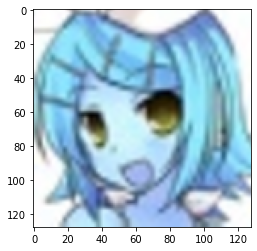

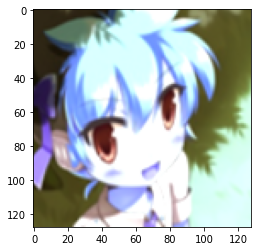

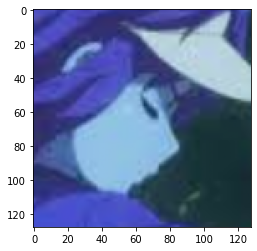

1749
438


In [13]:
for i in train_dl:
    plt.imshow(i[0][0].permute(1, 2, 0))#anchor
    plt.show()
    plt.imshow(i[1][0].permute(1, 2, 0)) #positive
    plt.show()
    plt.imshow(i[2][0].permute(1, 2, 0)) #negative
    plt.show()
    break
    
print(len(train_dl))
print(len(test_dl))

In [14]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)

In [15]:
loss = nn.TripletMarginLoss(margin=2.0, p=2)

In [178]:
from torch.utils.tensorboard import SummaryWriter

In [168]:
!pip install wandb -qqq
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [169]:
wandb.init(project="triplet_siamse_network", config={
    "learning_rate": 0.01,
    "architecture": "SNN"
})
config = wandb.config

train/accuracy,0.7
train/loss,2.01341
_runtime,8
_timestamp,1626956472
_step,0


train/accuracy,▁
train/loss,▁
_runtime,▁
_timestamp,▁
_step,▁


In [170]:
from statistics import mean

def train_model(model, epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
    writer = SummaryWriter('runs')
    
    for epoch in range(epochs):
        
        print('\n\n')
        print('------- EPOCH', epoch, '--------' )
        
        train_prebs_history = []
        train_loss_history = []
        train_accuracy_history = []
        
        test_accuracy_history = []
        test_preds_history = []
        test_loss_history = []
        
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(train_dl), total = len(train_dl)):

            optimizer.zero_grad()
            
            preds = model.forward(anchor, positive, negative)
            output = loss.forward(preds[0], preds[1], preds[2])
            
            train_loss_history.append(output)
            
            output.backward() #count gradients
            optimizer.step() #update weights
            
            cur_accuracy = accuracy(preds[0], preds[1], preds[2], batch_size)
            train_accuracy_history.append(cur_accuracy)
            wandb.log({"train/accuracy": cur_accuracy, "train/loss": output})
            
        print('train accuracy: ', mean(train_accuracy_history))
        print('train loss: ', sum(train_loss_history)/len(train_loss_history))
        

        
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(test_dl), total = len(test_dl)):
            
            test_preds = model.forward(anchor, positive, negative)
            cur_accuracy = accuracy(test_preds[0], test_preds[1], test_preds[2], batch_size)
            test_accuracy_history.append(cur_accuracy)
            wandb.log({"test/accuracy":cur_accuracy})
            
            with torch.no_grad():
                test_loss = loss.forward(test_preds[0], test_preds[1], test_preds[2])
                test_loss_history.append(test_loss)
                wandb.log({"test/loss": test_loss})
                
        print('test accuracy: ', mean(test_accuracy_history))
            

In [171]:
train_model(model)

  0%|                                                                                         | 0/1749 [00:00<?, ?it/s]




------- EPOCH 0 --------


  4%|███▏                                                                            | 71/1749 [01:21<32:17,  1.15s/it]


KeyboardInterrupt: 

In [172]:
from torchsummaryX import summary
for batch_idx, (a, p, n) in tqdm(enumerate(train_dl), total = len(train_dl)):
    summary(model, a, p, n)
    loss(a, p, n)
    break

  0%|                                                                                         | 0/1749 [00:00<?, ?it/s]

                                              Kernel Shape  \
Layer                                                        
0_embedding_net.conv_block1.Conv2d_0          [3, 9, 3, 3]   
1_embedding_net.conv_block1.ReLU_1                       -   
2_embedding_net.conv_block1.Conv2d_2         [9, 15, 3, 3]   
3_embedding_net.conv_block1.ReLU_3                       -   
4_embedding_net.conv_block1.MaxPool2d_4                  -   
5_embedding_net.conv_block2.Conv2d_0        [15, 18, 5, 5]   
6_embedding_net.conv_block2.ReLU_1                       -   
7_embedding_net.conv_block2.Conv2d_2        [18, 27, 5, 5]   
8_embedding_net.conv_block2.ReLU_3                       -   
9_embedding_net.conv_block2.MaxPool2d_4                  -   
10_embedding_net.conv_block2.Conv2d_5     [27, 33, 17, 17]   
11_embedding_net.conv_block2.ReLU_6                      -   
12_embedding_net.conv_block2.MaxPool2d_7                 -   
13_embedding_net.fc.Linear_0                    [825, 768]   
14_embed